<font size = 3> boosting方法的核心理念在于博采众长，正所谓"三个臭皮匠，顶个诸葛亮"，这也使得boosting方法要好于大多数单模型算法。一般来说，boosting方法都要解答两个关键问题：一是在训练过程中如何改变训练样本的权重或者是概率分布，二是如何将多个弱分类器组合成一个强分类器。针对这两个问题，Adaboost是做法非常朴素，第一个就是提高前一轮被弱分类器分类错误的样本的权重、而降低分类正确的样本权重；第二则是对多个弱分类器进行线性组合，提高分类效果好的弱分类器权重，减小分类误差率大的弱分类器权重。

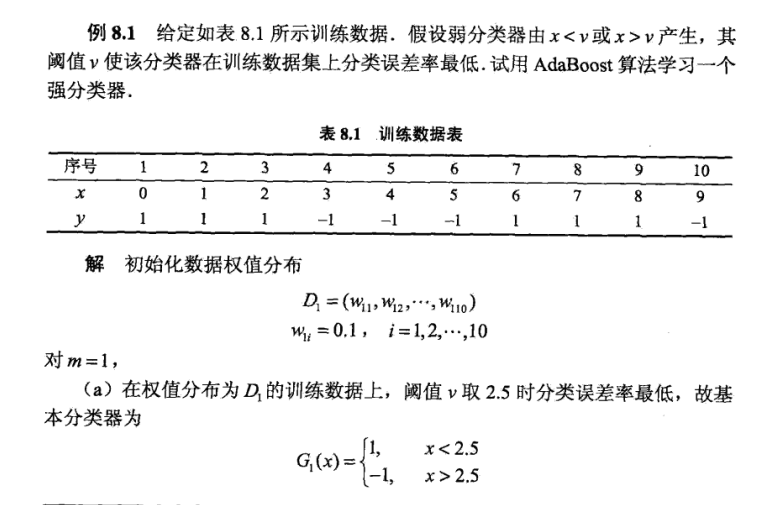

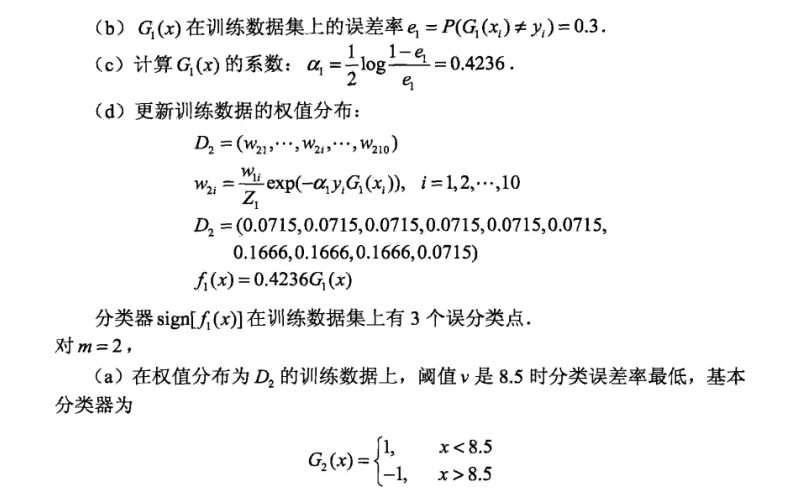

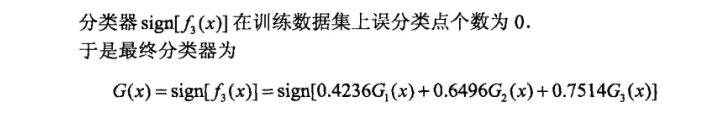

In [1]:
# 先定义一个决策树桩，本质上就是一个带有阈值划分的决策树结点。
class DecisionStump():
    def __init__(self):
        # 基于划分阈值决定样本分类为1还是-1
        self.polarity = 1
        # 特征索引
        self.feature_index = None
        # 特征划分阈值
        self.threshold = None
        # 指示分类准确率的值
        self.alpha = None

In [12]:
class Adaboost():
    # 弱分类器个数
    def __init__(self, n_estimators=5):
        self.n_estimators = n_estimators
    # Adaboost拟合算法
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # (1) 初始化权重分布为均匀分布 1/N
        w = np.full(n_samples, (1/n_samples)) #full.填充同一值为给定大小
        
        self.estimators = []
        # (2) for m in (1,2,...,M)
        for _ in range(self.n_estimators):
            # (2.a) 训练一个弱分类器：决策树桩
            clf = DecisionStump()
            # 设定一个最小化误差
            min_error = float('inf')
            # 遍历数据集特征，根据最小分类误差率选择最优划分特征
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)
                # 尝试将每一个特征值作为分类阈值
                for threshold in unique_values:
                    p = 1
                    # 初始化所有预测值为1
                    prediction = np.ones(np.shape(y))
                    # 小于分类阈值的预测值为-1
                    prediction[X[:, feature_i] < threshold] = -1
                    # 2.b 计算误差率
                    error = sum(w[y != prediction])
                    
                    # 如果分类误差大于0.5，则进行正负预测翻转考虑到标签打反？
                    # E.g error = 0.8 => (1 - error) = 0.2
                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # 一旦获得最小误差则保存相关参数配置
                    if error < min_error:
                        clf.polarity = p # 极性
                        clf.threshold = threshold #每个特征中的分界线
                        clf.feature_index = feature_i #那个特征名
                        min_error = error
                        
            # 2.c 计算基分类器的权重
            clf.alpha = 0.5 * math.log((1.0 - min_error) / (min_error + 1e-10)) #G(x)，最后的基分类器权重，也用于更新样本权重
            # 初始化所有预测值为1
            predictions = np.ones(np.shape(y))
            # 获取所有小于阈值的负类索引
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # 将负类设为 '-1'
            predictions[negative_idx] = -1 #更新y？对，就是在更新按这个分类器分类的结果   
            # 2.d 更新样本权重
            w *= np.exp(-clf.alpha * y * predictions)
            w /= np.sum(w)

            # 保存该弱分类器
            self.estimators.append(clf)
    
    # 定义预测函数
    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        # 计算每个弱分类器的预测值
        for clf in self.estimators:
            # 初始化所有预测值为1
            predictions = np.ones(np.shape(y_pred))
            # 获取所有小于阈值的负类索引
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # 将负类设为 '-1'
            predictions[negative_idx] = -1
            # 2.e 对每个弱分类器的预测结果进行加权
            y_pred += clf.alpha * predictions

        # 返回最终预测结果
        y_pred = np.sign(y_pred).flatten()
        return y_pred

In [14]:
import numpy as np
import math
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

data = datasets.load_digits()
X = data.data
y = data.target

digit1 = 1
digit2 = 8
idx = np.append(np.where(y==digit1)[0], np.where(y==digit2)[0])
y = data.target[idx]
# Change labels to {-1, 1}
y[y == digit1] = -1
y[y == digit2] = 1
X = data.data[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)



In [15]:

# 使用5个弱分类器
clf = Adaboost(n_estimators=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print ("Accuracy:", accuracy)

Accuracy: 0.872
